# Machine Learning Project (Drug Design)
#### Approach to the problem
1- **Selection of the Network Architecture (VAE composed of LSTM Encoder & Decoder)**
- Data collection in **SMILES** format.
- SMILES represent the chemical compounds in string format.
- Since this is a **sequence task, LSTM** is the preferred choice of the neural network architecture for generating new SMILES string.

2- **Data Preprocessing Steps**
- Collect all the **unique characters** from the dataset.
- Create **two dictionaries**, one mapping all the unique characters to the index while the other mapping index back to character.
- Encode all the SMILES string into **one hot vectors** (character based) to feed into the network.
- Append **start token** at the beginning of each SMILE string and **end token** to mark the end of the string.
- Make all the SMILES string of **same length** for training in batch by padding smaller SMILE strings with end token.
- **Labels will be shifted** by one unit from the inputs for **teacher forcing method** to train the sequence model.
- Build the lstm encoder and decoder network.
- Train the network end to end using one hot encoded SMILES string.

3- **Inference from the decoder**
- After training the network, feed random samples to the decoder to generate new SMILES string.

## Import necessary modules

In [4]:
import os
import tarfile
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K

tf.random.set_seed(1234)

### Set up google drive and extract data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Extract data from zip file

In [6]:
zip_dir = '/content/drive/MyDrive/ZINC_DATASET/gdb11.tgz'
extract_dir = '/tmp/'
tar = tarfile.open(zip_dir, 'r')
tar.extractall(extract_dir)
tar.close()

In [7]:
# list the contents of extract_dir
os.listdir(extract_dir)

['gdb11_size05.smi',
 'drive.b049de3f298c.root.log.INFO.20230901-195522.1356',
 'drive.b049de3f298c.root.log.INFO.20230901-195514.1359',
 'drive.b049de3f298c.root.log.WARNING.20230901-195522.1463',
 'drive.b049de3f298c.root.log.INFO.20230901-195522.1463',
 'dap_multiplexer.INFO',
 'language_service.b049de3f298c.root.log.INFO.20230901-195206.522',
 'drive.b049de3f298c.root.log.ERROR.20230901-195522.1463',
 'initgoogle_syslog_dir.0',
 'gdb11_size01.smi',
 'drivefs_ipc.0_shell',
 'drive.INFO',
 'gdb11_size04.smi',
 'debugger_1nxboi1eow',
 'gdb11_size03.smi',
 'gdb11_size08.smi',
 'gdb11_size06.smi',
 'drive.b049de3f298c.root.log.INFO.20230901-195514.1356',
 'language_service.INFO',
 'gdb11_size02.smi',
 'dap_multiplexer.b049de3f298c.root.log.INFO.20230901-195038.105',
 'python-languageserver-cancellation',
 'gdb11_size07.smi',
 'drive.WARNING',
 'drive.ERROR',
 'drivefs_ipc.0',
 'gdb11_size10.smi',
 'pyright-530-vrN5ydR2T0RU',
 'pyright-530-HZlj21UuTdEU',
 'gdb11_size11.smi',
 'gdb11_size

### Load smiles data into pandas dataframe

In [8]:
smi_file = extract_dir + "gdb11_size09.smi"
data_df = pd.read_csv(smi_file, delimiter = "\t", names = ['smiles', 'col_2', 'col_3'])
data_df.head()

,smiles,col_2,col_3
0,CC(C)(C)CC(C)(C)C,1,1
1,CC(C)(C)CC(C)(C)N,2,1
2,CC(C)(C)CC(C)(C)O,3,1
3,CC(C)(C)CC(C)(C)F,4,1
4,CC(C)(C)CC(C)(F)F,5,1


### Train and validation split

In [9]:
# split the data into train and validation set
x_train, x_val = train_test_split(data_df['smiles'], test_size = 0.1, random_state = 42)

print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of x_val: {x_val.shape}')

Shape of x_train: (399881,)
Shape of x_val: (44432,)


### Dictionary of unique characters

In [10]:
# Unique character set with start and end tokens
char_set = set(''.join(list(data_df.smiles)) + '!E')

# character to int mapping
char_to_int = dict((c, i) for i, c in enumerate(char_set))

# int to character mapping
int_to_char = dict((i, c) for i, c in enumerate(char_set))

# maximum length of sequence
seq_len = max([len(smile) for smile in data_df.smiles]) + 2

print(f'Character to integer dictionary: \n {char_to_int}')
print('\n')
print(f'Integer to character dictionary: \n {int_to_char}')

Character to integer dictionary: 
 {'5': 0, 'H': 1, 'N': 2, ']': 3, 'F': 4, '=': 5, 'c': 6, '3': 7, '[': 8, '2': 9, '#': 10, '-': 11, '!': 12, 'C': 13, 'O': 14, '1': 15, '+': 16, 'E': 17, ')': 18, '4': 19, 'o': 20, '(': 21, 'n': 22}


Integer to character dictionary: 
 {0: '5', 1: 'H', 2: 'N', 3: ']', 4: 'F', 5: '=', 6: 'c', 7: '3', 8: '[', 9: '2', 10: '#', 11: '-', 12: '!', 13: 'C', 14: 'O', 15: '1', 16: '+', 17: 'E', 18: ')', 19: '4', 20: 'o', 21: '(', 22: 'n'}


In [11]:
print(f'Character set: {str(char_set)}')
print(f'Number of characters: {len(char_set)}\t Length of sequence: {seq_len}')

Character set: {'5', 'H', 'N', ']', 'F', '=', 'c', '3', '[', '2', '#', '-', '!', 'C', 'O', '1', '+', 'E', ')', '4', 'o', '(', 'n'}
Number of characters: 23	 Length of sequence: 31


### One hot encoding of sequence data

In [12]:
def one_hot_encoding(smiles_col):
  # array of shape (num_examples, time_stamp, input_dim) initialized with zeros
  one_hot =  np.zeros((smiles_col.shape[0], seq_len, len(char_set)), dtype = np.int8)
  # iterate over each smile string
  for index, smile in enumerate(smiles_col):
    # encode the start token
    one_hot[index, 0, char_to_int["!"]] = 1
    # encode the characters of smile string
    for row, char in enumerate(smile):
        one_hot[index, row + 1, char_to_int[char]] = 1
    # encode the end token
    one_hot[index, len(smile) + 1:, char_to_int['E']] = 1
  # return input and the output
  return one_hot[:, 0:-1, :], one_hot[:, 1:, :]

### Visualize the one hot encoded data

CC(=O)OC1(C)CC1O


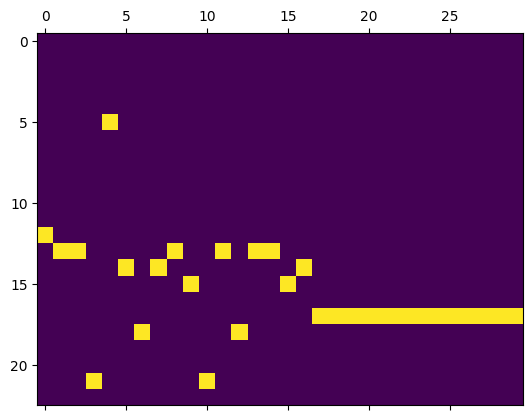

In [13]:
# One hot encoded train and validation data
X_train, Y_train = one_hot_encoding(x_train.values)
X_val, Y_val = one_hot_encoding(x_val.values)

# Print the first smile string
print(x_train.iloc[0])

# show the one hot encoded version of the string
plt.matshow(X_train[0].T)

In [14]:
# print the first smile string sequence with start and end tokens
"".join([int_to_char[idx] for idx in np.argmax(X_train[0, :, :], axis = 1)])

'!CC(=O)OC1(C)CC1OEEEEEEEEEEEEE'

In [15]:
# input shape of the model
input_shape = X_train.shape[1:]

# output shape of the model
output_dim = Y_train.shape[-1]

# latent dimension
latent_dim = 64

# lstm units
lstm_dim = 64

### Build Encoder Model

In [16]:
# input layer of the encoder
encoder_inputs = layers.Input(shape = input_shape)

# internal states of the encoder (default activation is tanh)
outputs, state_h, state_c = layers.LSTM(lstm_dim, return_state = True, unroll = False)(encoder_inputs)

# concatenation of cell state and hidden state
concat_states = layers.Concatenate(axis = -1)([state_h, state_c])

latent_outputs = layers.Dense(latent_dim, activation = "relu")(concat_states)

### Model building

In [17]:
# decode the cell and hidden states of the encoder
h_decoded =  layers.Dense(lstm_dim, activation = "relu")(latent_outputs)
c_decoded =  layers.Dense(lstm_dim, activation = "relu")(latent_outputs)

# decoded states
decoded_states = [h_decoded, c_decoded]

# input layer for decoder
decoder_inputs = layers.Input(shape = input_shape)

# hidden layers
decoder_lstm = layers.LSTM(lstm_dim, return_sequences = True, unroll = False)
decoder_outputs = decoder_lstm(decoder_inputs, initial_state = decoded_states)
decoder_outputs = layers.Dense(output_dim, activation = 'softmax')(decoder_outputs)

# Define the model
model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

# print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 23)]     0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 64),         22528       ['input_1[0][0]']                
                                 (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                                  
 concatenate (Concatenate)      (None, 128)          0           ['lstm[0][1]',                   
                                                                  'lstm[0][2]']               

### **Compile and fit the model**


Stopped after 65th iteration

In [19]:
# set learning rate for the model
learning_rate = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 10, min_lr = 0.000001, verbose = 1, min_delta = 1e-5)

# set the optimizer for the model
opt = tf.keras.optimizers.Adam(lr = 0.005)

# compile the model
model.compile(optimizer = opt, loss = 'categorical_crossentropy')

# fit the model
model.fit([X_train, X_train], Y_train, epochs = 100, batch_size = 256, shuffle = True, callbacks = [learning_rate], validation_data = ([X_val, X_val], Y_val))

Epoch 1/100
1563/1563 [==============================] - 21s 11ms/step - loss: 0.0023 - val_loss: 0.0030 - lr: 0.0010
Epoch 2/100
1563/1563 [==============================] - 25s 16ms/step - loss: 0.0038 - val_loss: 0.0010 - lr: 0.0010
Epoch 3/100
1563/1563 [==============================] - 16s 10ms/step - loss: 0.0061 - val_loss: 8.4071e-04 - lr: 0.0010
Epoch 4/100
1563/1563 [==============================] - 17s 11ms/step - loss: 0.0022 - val_loss: 8.4294e-04 - lr: 0.0010
Epoch 5/100
1563/1563 [==============================] - 16s 10ms/step - loss: 0.0030 - val_loss: 0.0011 - lr: 0.0010
Epoch 6/100
1563/1563 [==============================] - 16s 10ms/step - loss: 0.0040 - val_loss: 0.0014 - lr: 0.0010
Epoch 7/100
1563/1563 [==============================] - 18s 12ms/step - loss: 0.0023 - val_loss: 0.0019 - lr: 0.0010
Epoch 8/100
1563/1563 [==============================] - 17s 11ms/step - loss: 7.1658e-04 - val_loss: 0.0011 - lr: 0.0010
Epoch 9/100
1563/1563 [=====================

KeyboardInterrupt: ignored

### Model predictions on validation set

In [20]:
for i in range(100):
  # extract index of maximum probability
  idxs_pred = np.argmax(model.predict([X_val[i:i + 1], X_val[i:i + 1]]), axis = 2)

  # join the predicted smile string
  pred_smile = "".join([int_to_char[m] for m in idxs_pred[0]])[:-1]

  # original smile string
  idxs_original = np.argmax(X_val[i:i + 1], axis = 2)
  true_smile =  "".join([int_to_char[n] for n in idxs_original[0]])[1:]
  if true_smile != pred_smile:
    print(f'True smile representation: {true_smile}\n Predicted smile representation: {pred_smile}')

1/1 [==============================] - 0s 23ms/step


### Smiles to latent space

In [21]:
# construct the smiles to latent space model
smiles_to_latent_space = tf.keras.Model(encoder_inputs, latent_outputs)

# save the model
smiles_to_latent_space.save("smile_latent.h5")

In [22]:
# convert validation data into latent space
val_latent = smiles_to_latent_space.predict(X_val)

1389/1389 [==============================] - 3s 2ms/step


### Latent space to lstm states

In [23]:
# latent input layer for decoding smiles data
latent_input = layers.Input(shape = (latent_dim,))

# reuse earlier dense layers
state_h_decoded =  model.get_layer('dense_1')(latent_input)
state_c_decoded =  model.get_layer('dense_2')(latent_input)

latent_to_states_model = tf.keras.Model(latent_input, [state_h_decoded, state_c_decoded])
latent_to_states_model.save("latent_state.h5")

In [24]:
# Model for random sampling
sample_decoder_inputs = layers.Input(batch_shape = (1, 1, input_shape[1]))
lstm_out = layers.LSTM(lstm_dim, return_sequences = True, unroll = False, stateful = True)(sample_decoder_inputs)
dense_out = layers.Dense(output_dim, activation = 'softmax')(lstm_out)

sample_model = tf.keras.Model(sample_decoder_inputs, dense_out)

In [25]:
# Model for random sampling
inf_decoder_inputs = layers.Input(batch_shape = (1, 1, input_shape[1]))
inf_decoder_lstm = layers.LSTM(lstm_dim, return_sequences = True, unroll = False, stateful = True)

inf_decoder_outputs = inf_decoder_lstm(inf_decoder_inputs)
inf_decoder_dense = layers.Dense(output_dim, activation = 'softmax')
inf_decoder_outputs = inf_decoder_dense(inf_decoder_outputs)

sample_model = tf.keras.Model(inf_decoder_inputs, inf_decoder_outputs)

In [26]:
# Transfer learned weights
for i in range(1, 3):
  sample_model.layers[i].set_weights(model.layers[i + 6].get_weights())
sample_model.save("sample_model.h5")

sample_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(1, 1, 23)]              0         
                                                                 
 lstm_3 (LSTM)               (1, 1, 64)                22528     
                                                                 
 dense_5 (Dense)             (1, 1, 23)                1495      
                                                                 
Total params: 24,023
Trainable params: 24,023
Non-trainable params: 0
_________________________________________________________________


### This function will generate smiles from latent space

In [27]:
def latent_to_smiles(latent):
  # decode states and Reset the LSTM cells
  states = latent_to_states_model.predict(latent)
  sample_model.layers[1].reset_states(states = [states[0], states[1]])
  # Prepare the input char
  start_idx = char_to_int["!"]
  sample_vec = np.zeros((1, 1, 23))
  sample_vec[0, 0, start_idx] = 1
  smiles = ""
  # Loop and predict next char
  for i in range(28):
    out = sample_model.predict(sample_vec)
    sample_idx = np.argmax(out)
    sample_char = int_to_char[sample_idx]
    if sample_char != "E":
      smiles = smiles + int_to_char[sample_idx]
      sample_vec = np.zeros((1, 1, 23))
      sample_vec[0, 0, sample_idx] = 1
    else:
      break
  return smiles

### First generated SMILE string

In [28]:
smiles = latent_to_smiles(val_latent[0:1])
smiles

1/1 [==============================] - 0s 19ms/step


'CC1=C2OCC=C2C=C1'

### Second generated SMILE string

In [29]:
smiles = latent_to_smiles(val_latent[1:2])
smiles

1/1 [==============================] - 0s 18ms/step


'CC(O)C=C(F)C1CO1'

### Third generated SMILE string

In [30]:
smiles = latent_to_smiles(val_latent[2:3])
smiles

1/1 [==============================] - 0s 35ms/step


'ONC(=N)C1=CCC=C1'